In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import StringLookup
import matplotlib.pyplot as plt

In [2]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)  # Pass kwargs to the superclass
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [3]:
# Load the trained model
model_path = "my_model.h5"
model = load_model(model_path, custom_objects={"CTCLayer": CTCLayer})

In [4]:
# Define constants
image_width = 128
image_height = 32
padding_token = 99
max_len = 25  # Update this to match the max length from training if it differs.

In [5]:
characters = ['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [6]:
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [7]:
# Function to preprocess input image
def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [8]:
# Define the function for resizing and padding
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    pad_height_top = pad_height // 2
    pad_height_bottom = pad_height - pad_height_top
    pad_width_left = pad_width // 2
    pad_width_right = pad_width - pad_width_left

    image = tf.pad(
        image,
        paddings=[[pad_height_top, pad_height_bottom], [pad_width_left, pad_width_right], [0, 0]],
    )
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [9]:
# Function to decode the prediction
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_len]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [10]:
# Load and preprocess test image
image_path = "test/like.png"  # Update this with your test image path
image = preprocess_image(image_path)
image = tf.expand_dims(image, axis=0)  # Add batch dimension

In [11]:
# Predict and decode
prediction_model = tf.keras.Model(inputs=model.input[0], outputs=model.get_layer(name="dense2").output)
pred = prediction_model.predict(image)
predicted_text = decode_batch_predictions(pred)
print(f"Predicted Text: {predicted_text[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
Predicted Text: like


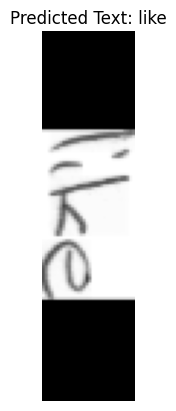

In [12]:
# Display the image and prediction
plt.imshow(tf.squeeze(image), cmap="gray")
plt.title(f"Predicted Text: {predicted_text[0]}")
plt.axis("off")
plt.show()